# Wprowadzenie

Poniżej przykład analizy szeregów czasowych, o którym rozmawialiśmy na ćwiczeniach bez projektora :) 

Analizowane będą dane dot. ilości pasażerów linii lotniczych w czasie - pokażę Państwu, jak zrobić na tych danych rozbiór na składowe (trend/sezonowość/błędy), jak przeprowadzić analizę wartości resztowych oraz modelować za pomocą procedury ARIMA

Strony internetowe, na których można znaelźć bardzo szczegółowe tutoriale i poradniki odnośnie analizy szeregów czasowych znajdą Państwo poniżej:

* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

# Przygotowanie techniczne

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

C:\Users\fwojcik\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

# Wczytanie danych

In [3]:
airpass_df = pd.read_csv("./AirPassengers.csv")
airpass_df.columns = ['date', 'passengers']
airpass_df.iloc[:10]

,date,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


Tworzymy obiekt szeregu czasowego - jeden wektor obserwacji indeksowany datami

In [4]:
ts = pd.Series(data=airpass_df.passengers.values, index=pd.to_datetime(airpass_df.date))

# Rzutowanie na typ "float" czyli liczby zmiennoprzecinkowe
ts = ts.astype(float)

In [5]:
ts[:10]

date
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
dtype: float64

Rysowanie wykresu:

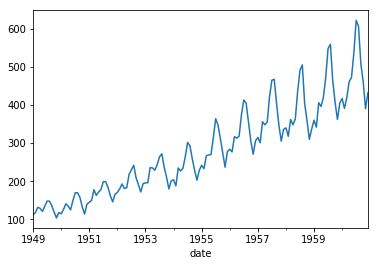

In [6]:
ts.plot()

Z wykresu widzimy wyraźnie, że szereg jest:
* rosnący (trend)
* sezonowy
* wariancja rośnie w czasie (zwiększanie się rozstrzału)

# Operacje na szeregach czasowych

## Sprawdzanie autokrelacji

Wykres autokorelacji. Sprawdzamy jak skorelowane są ze sobą obserwacje w czasie - tzn. jak obserwacja w czasie t, ma się do t-1, t-2, t-3, ..., t-n.

* Silniejsza korelacja oznacza oczywiście, że będziemy mogli to wykorzystać w analizie
* poziomie linie oznaczają przedziały istotności statystycznej dla założenia, że szereg jest tzw. białym szumem -że obserwacje są os siebie całkowicie niezależne. Jeśli WSZYSTKIE obserwacje mieszczą się w tym paśmie - znaczy to, że szereg jest losowy i nie zawiera korelacji

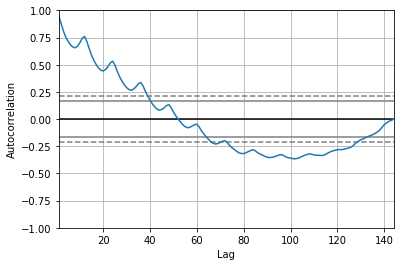

In [7]:
autocorrelation_plot(ts)

## Rozbiór na trend i sezonowość

In [8]:
decomposition = seasonal_decompose(ts)
trend, season, err = decomposition.trend, decomposition.seasonal, decomposition.resid

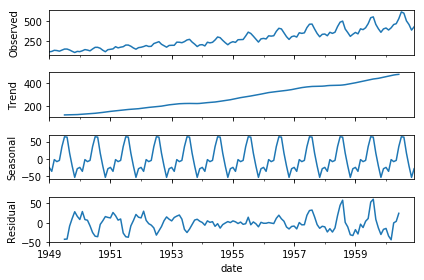

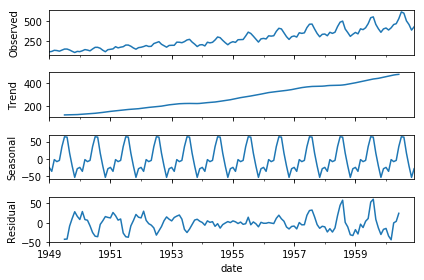

In [9]:
decomposition.plot()

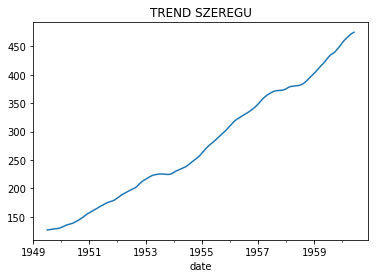

In [10]:
trend.plot(title="TREND SZEREGU")

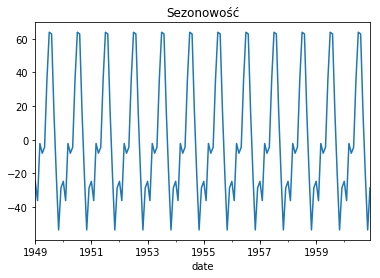

In [11]:
season.plot(title="Sezonowość")

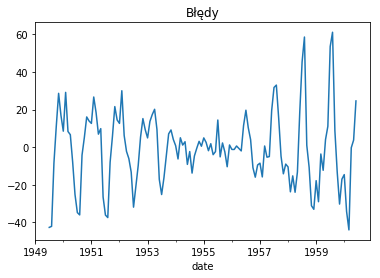

In [12]:
err.plot(title="Błędy")

Możemy przeprowadzić na błędach test Ljunga-Boxa, żeby sprawdzić, czy na pewno są to wartości losowe:

Ponieważ nasz szereg jest rosnący w czasie, musimy dokonać operacji **różnicowania**, która znormalizuje szereg i pozwoli znaleźć odpowiednie parmaetry.

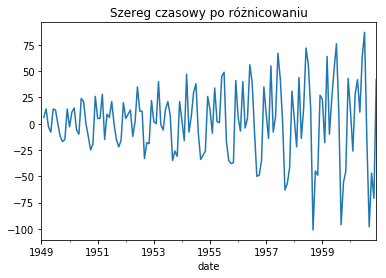

In [13]:
ts_diff = ts.diff()
ts_diff.plot(title="Szereg czasowy po różnicowaniu")

Sprawdzamy wykresdy autokorelacji i autokorelacji cząstkowych. Więcej na ten temat:

https://onlinecourses.science.psu.edu/stat501/node/358

Funcja ACF i PACf pokazują nam, do jakiego stopnia obserwacje aktualne są zależne od obserwacji z przeszłości. Jest to istone dla modelowania ARIMA - parametr AR i MA będzie wyznaczany w oparciu o te wykresy.

(Bardzo) Upraszczając, można powiedzieć, iż **parametr AR będzie równy ilości obserwacji (w czasie), kiedy po raz ostatni słupek na wykresie ACF jest powyżej linii przedziałów ufności**.

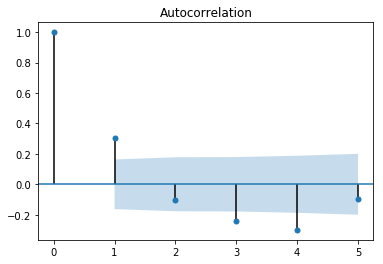

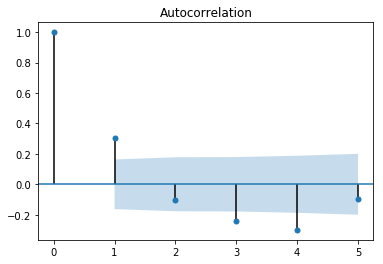

In [14]:
plot_acf(ts_diff.fillna(0), lags=[0,1,2,3,4,5])

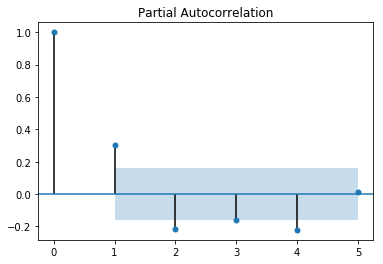

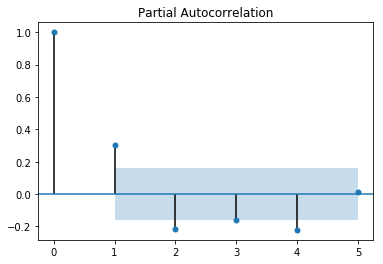

In [15]:
plot_pacf(ts_diff.fillna(0), lags=[0,1,2,3,4,5])

Wykresy sugerują wartości autokorelacji (ACF) i PACF w okolicach 1 - w przypadku obu funkcji słupki wykresów dotykają linii istotności 95% po raz ostatni.

## Modelowanie ARIMA

Możemy przystąpić do modelowania. Co już wiemy:

* mniej-więcej oszacowaliśmy parametry modelu ARIMA: AR ~ 1, MA ~ 1
* szereg musi być różnicowany, że względu na rosnący charakter trendu. Różnicowanie D na poziomie 1 również wydaje się ok.

Mamy zatem:

**AR = 1, MA = 1, I/D = 1**

In [16]:
model = ARIMA(ts, order=(1,1,1))
results = model.fit()

Dokonujemy predykcji na przyszłość:

In [17]:
ts.index.max()

Timestamp('1960-12-01 00:00:00')

In [18]:
forecast = results.predict(start='1960-12-01', end="1961-12-01", )

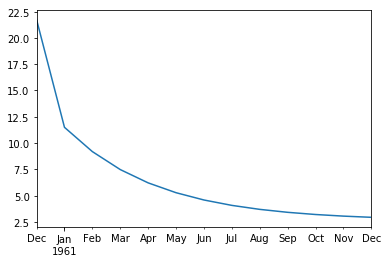

In [19]:
forecast.plot()